在这个工作是是将航班频次作为边的权重

# 加载数据

In [19]:
import pandas as pd
# 加载数据
# data = pd.read_csv('../my/hh_result/result_all.csv', dtype={'flt_no': str})
# data_24 = pd.read_csv('../my/hh_result/result_24_7-10.csv', dtype={'flt_no': str})
data = pd.read_csv('data_hh/result/pre_2023-2025_with_comp.csv', dtype={'flt_no': str})

# 查看前几行数据，确保加载成功
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1905469 entries, 0 to 1905468
Data columns (total 20 columns):
 #   Column            Dtype  
---  ------            -----  
 0   flt_no            object 
 1   cap               float64
 2   aircraft          object 
 3   legs              int64  
 4   leg_no            int64  
 5   duration          float64
 6   pax               int64  
 7   a                 object 
 8   b                 object 
 9   c                 object 
 10  unit_price        float64
 11  competitor_price  float64
 12  year              int64  
 13  month             int64  
 14  day               int64  
 15  weekday           int64  
 16  hour              int64  
 17  minute            int64  
 18  from              object 
 19  to                object 
dtypes: float64(4), int64(9), object(7)
memory usage: 290.8+ MB
None


## 统计不同城市的频率

In [20]:
# 将 from 和 to 两列合并，并统计每个城市的出现次数
city_count_series = pd.concat([data['from'], data['to']]).value_counts()

# 转换为 city_count 数据框
city_count = city_count_series.reset_index()
city_count.columns = ['city', 'count']

# 3. 创建 city_map，将每个城市映射为其出现次数（或者任何你需要的值）
city_map = dict(zip(city_count['city'], city_count['count']))

# 输出结果
print(city_count)

    city   count
0    e5a  152496
1    dcf  107696
2    792   89355
3    ea1   87446
4    24c   87231
..   ...     ...
373  430       1
374  bba       1
375  a49       1
376  591       1
377  f8e       1

[378 rows x 2 columns]


In [21]:
import json

# 保存 city_map 到 JSON 文件
with open('data_hh/result/encoder/city_map_频率编码.json', 'w') as f:
    json.dump(city_map, f)

print("city_map_频率编码 已保存到 city_map_频率编码")

city_map_频率编码 已保存到 city_map_频率编码


### 'flt_no', 'bd_type', 'aircraft'编码

In [22]:
import joblib
from sklearn.preprocessing import LabelEncoder
import os

# 定义需要编码的分类特征
# categorical_columns = ['flt_no', 'bd_type', 'aircraft', 'a', 'b', 'c', 'from', 'to']
# categorical_columns = ['flt_no', 'bd_type', 'aircraft']
categorical_columns = ['flt_no', 'aircraft']


# 创建并应用 LabelEncoder
label_encoders = {}

# 创建保存编码器的文件夹（如果文件夹不存在）
save_folder = 'data_hh/result/encoder/'
os.makedirs(save_folder, exist_ok=True)  # 如果文件夹已存在，不会报错

# 遍历每个分类特征，使用 LabelEncoder 对其进行编码
for col in categorical_columns:
    le = LabelEncoder()  # 创建一个 LabelEncoder 实例
    data[col] = le.fit_transform(data[col])  # 对训练数据中的分类特征进行编码
    label_encoders[col] = le  # 将每个特征的编码器保存到字典中，方便后续使用

    # 保存每个编码器到指定文件夹
    encoder_path = os.path.join(save_folder, f"{col}_encoder_all.pkl")  # 构建保存路径
    joblib.dump(le, encoder_path)  # 使用 joblib 将编码器保存为 pkl 文件
    print(f"{col} 的编码器已保存为 {encoder_path}")  # 输出保存的路径

flt_no 的编码器已保存为 data_hh/result/encoder/flt_no_encoder_all.pkl
aircraft 的编码器已保存为 data_hh/result/encoder/aircraft_encoder_all.pkl


## 生成加权图

In [23]:
# 创建一个新的数据框，用于存储航班频数
flight_counts = data.groupby(['from', 'to']).size().reset_index(name='flight_count')

# 打印查看
print(flight_counts.shape)
print(flight_counts.head())


(2744, 3)
  from   to  flight_count
0  000  13f           272
1  000  8e3           852
2  000  a18             1
3  000  eda           421
4  01a  b5a            75


In [24]:
import networkx as nx

# 创建一个空图
G = nx.Graph()

# 将城市作为节点，航班频数作为边的权重添加到图中
for index, row in flight_counts.iterrows():
    G.add_edge(row['from'], row['to'], weight=row['flight_count'])

# 输出图的基本信息
print("图的节点数:", G.number_of_nodes())
print("图的边数:", G.number_of_edges())

图的节点数: 378
图的边数: 2744


/home/zhanyu/anaconda3/envs/machine/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21152 (\N{CJK UNIFIED IDEOGRAPH-52A0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zhanyu/anaconda3/envs/machine/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26435 (\N{CJK UNIFIED IDEOGRAPH-6743}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zhanyu/anaconda3/envs/machine/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 33322 (\N{CJK UNIFIED IDEOGRAPH-822A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zhanyu/anaconda3/envs/machine/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29677 (\N{CJK UNIFIED IDEOGRAPH-73ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zhanyu/anaconda3/envs/machine/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWar

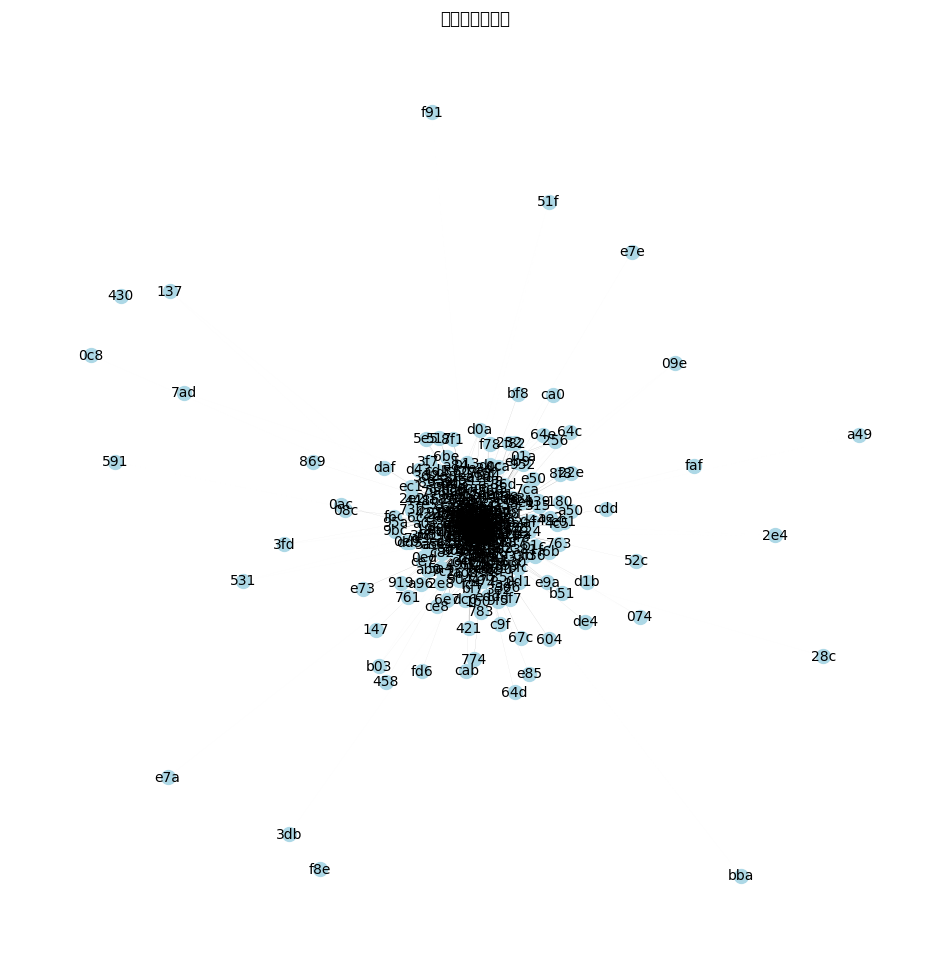

In [25]:
import matplotlib.pyplot as plt

# 设置图的布局
plt.figure(figsize=(12, 12))

# 绘制加权图，边的宽度表示航班频数
pos = nx.spring_layout(G, k=0.5)  # 使用 spring 布局来可视化图
edges = G.edges(data=True)

# 绘制节点
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue')

# 绘制边，边的宽度表示航班频数（weight）
nx.draw_networkx_edges(G, pos, width=[d['weight'] / 1000 for u, v, d in edges], alpha=0.5)

# 绘制节点标签
nx.draw_networkx_labels(G, pos, font_size=10)

# 显示图形
plt.title("加权航班网络图")
plt.axis('off')
plt.show()

## 创建并训练 DeepWalk 模型

In [26]:
import numpy
print(numpy.__version__)

1.23.5


In [27]:
import networkx as nx
from node2vec import Node2Vec

1. 加载图并准备数据

In [28]:
node2vec = Node2Vec(G, 
                   dimensions=64, 
                   walk_length=3, 
                   num_walks=2000, 
                   workers=4,
                   weight_key='weight')

model = node2vec.fit(window=3, 
                    min_count=1, 
                    batch_words=64)

Computing transition probabilities:   0%|          | 0/378 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 500/500 [00:02<00:00, 234.24it/s]


2. 获取节点的嵌入向量

In [29]:
# 获取城市嵌入表示
city_embeddings = {}
for city in G.nodes():
    city_embeddings[city] = model.wv[city]  # 从模型中提取城市嵌入

# 打印第一个城市的嵌入表示
print(city_embeddings[list(G.nodes())[0]])

[ 0.67104316 -1.6169832  -0.5788622   0.06296697  0.36585116  0.23607044
 -0.5591259  -0.38683346 -0.76602054  0.47060022  0.37195396 -0.8946023
 -0.4806881  -0.36608872  0.31326407  0.37085792  0.5589587   0.13975842
 -0.4778311   1.1072364   0.41359353  0.5174057  -0.26746488  0.7623391
  0.47522572  1.1862983  -0.09908412  0.18376699  0.23235078 -0.05443653
  0.11077046  0.45526975 -1.2211087  -0.5923299  -0.08533631  0.75902086
  0.53087854 -0.5635508  -0.20495471  0.25422424  0.45808163 -0.6178425
 -0.11286642 -0.21092732  0.34817353 -0.13281584  0.08593711  0.50936997
  0.34951425 -0.36292785  0.6721144  -0.41905698  0.43170562  0.483618
  0.12749286  0.57450014  0.46972305  0.04309509 -0.49900463  0.12930007
  0.16322686 -1.0546092   0.04973209  1.0190802 ]


city_embeddings是一个字典

## 进行聚类

步骤 3：使用嵌入向量进行下游任务（例如聚类）

In [30]:
from sklearn.cluster import KMeans
import numpy as np

# 提取嵌入向量
embeddings = np.array([city_embeddings[city] for city in G.nodes()])

# 使用 KMeans 聚类
kmeans = KMeans(n_clusters=3, random_state=42)  # 设置簇的数量为3
kmeans.fit(embeddings)

# 查看每个城市的聚类标签
city_labels = dict(zip(G.nodes(), kmeans.labels_))

# 打印城市及其对应的聚类标签
for city, label in city_labels.items():
    print(f"城市: {city}, 聚类标签: {label}")


城市: 000, 聚类标签: 2
城市: 13f, 聚类标签: 0
城市: 8e3, 聚类标签: 0
城市: a18, 聚类标签: 0
城市: eda, 聚类标签: 2
城市: 01a, 聚类标签: 1
城市: b5a, 聚类标签: 0
城市: ea1, 聚类标签: 0
城市: 03f, 聚类标签: 2
城市: 1be, 聚类标签: 0
城市: 3bc, 聚类标签: 0
城市: 578, 聚类标签: 0
城市: 5df, 聚类标签: 0
城市: 5fb, 聚类标签: 0
城市: 760, 聚类标签: 0
城市: 792, 聚类标签: 0
城市: 7ff, 聚类标签: 0
城市: 90a, 聚类标签: 0
城市: 974, 聚类标签: 0
城市: bbb, 聚类标签: 0
城市: cb5, 聚类标签: 0
城市: ffe, 聚类标签: 0
城市: 059, 聚类标签: 2
城市: 022, 聚类标签: 0
城市: 077, 聚类标签: 0
城市: 0d7, 聚类标签: 0
城市: 0dd, 聚类标签: 0
城市: 1a3, 聚类标签: 0
城市: 1e9, 聚类标签: 0
城市: 1ed, 聚类标签: 0
城市: 25c, 聚类标签: 0
城市: 311, 聚类标签: 0
城市: 354, 聚类标签: 0
城市: 451, 聚类标签: 0
城市: 510, 聚类标签: 0
城市: 5d7, 聚类标签: 0
城市: 63a, 聚类标签: 0
城市: 666, 聚类标签: 0
城市: 6e3, 聚类标签: 0
城市: 7f1, 聚类标签: 0
城市: 812, 聚类标签: 0
城市: 8a1, 聚类标签: 0
城市: 9d4, 聚类标签: 0
城市: 9e9, 聚类标签: 0
城市: b3a, 聚类标签: 0
城市: bff, 聚类标签: 0
城市: c24, 聚类标签: 0
城市: c3a, 聚类标签: 0
城市: c4c, 聚类标签: 0
城市: c98, 聚类标签: 0
城市: c9f, 聚类标签: 0
城市: cb7, 聚类标签: 0
城市: d7c, 聚类标签: 0
城市: e76, 聚类标签: 0
城市: e9c, 聚类标签: 0
城市: efb, 聚类标签: 0
城市: 05c, 聚类标签: 2
城市: 141, 聚类标签: 0
城市: 157, 聚类标签:

### 保存聚类标签

In [31]:
# 首先导入 json 模块
import json
print(city_labels)

# 将字典中的所有值转换为 Python 的原生 int 类型
city_labels = {key: int(value) for key, value in city_labels.items()}

# 保存字典到 JSON 文件
with open('data_hh/result/encoder/city_labels_航班频率加权图标签.json', 'w') as file:
    json.dump(city_labels, file)

print("字典已保存为 city_labels.json")

{'000': 2, '13f': 0, '8e3': 0, 'a18': 0, 'eda': 2, '01a': 1, 'b5a': 0, 'ea1': 0, '03f': 2, '1be': 0, '3bc': 0, '578': 0, '5df': 0, '5fb': 0, '760': 0, '792': 0, '7ff': 0, '90a': 0, '974': 0, 'bbb': 0, 'cb5': 0, 'ffe': 0, '059': 2, '022': 0, '077': 0, '0d7': 0, '0dd': 0, '1a3': 0, '1e9': 0, '1ed': 0, '25c': 0, '311': 0, '354': 0, '451': 0, '510': 0, '5d7': 0, '63a': 0, '666': 0, '6e3': 0, '7f1': 0, '812': 0, '8a1': 0, '9d4': 0, '9e9': 0, 'b3a': 0, 'bff': 0, 'c24': 0, 'c3a': 0, 'c4c': 0, 'c98': 0, 'c9f': 0, 'cb7': 0, 'd7c': 0, 'e76': 0, 'e9c': 0, 'efb': 0, '05c': 2, '141': 0, '157': 0, '709': 0, '8ac': 0, '97f': 0, '988': 0, 'a2f': 0, 'b09': 0, 'c14': 0, 'c4b': 0, 'e5b': 0, 'ec2': 0, '074': 1, '4d0': 0, '695': 0, 'c2c': 0, 'fa9': 0, '08c': 2, '08f': 2, '3c5': 0, '5e8': 0, 'a72': 0, 'd54': 0, 'ff1': 0, '0ac': 1, '0c8': 1, '0ca': 1, 'e09': 0, '0d1': 1, '13e': 0, '1ee': 0, '43e': 0, '0db': 2, '919': 0, 'd08': 0, '0ff': 2, '11b': 1, '123': 2, '5de': 0, '8eb': 0, '124': 1, '130': 2, '1bf': 0,

## 二维空间聚类效果展示

步骤 4：可视化嵌入

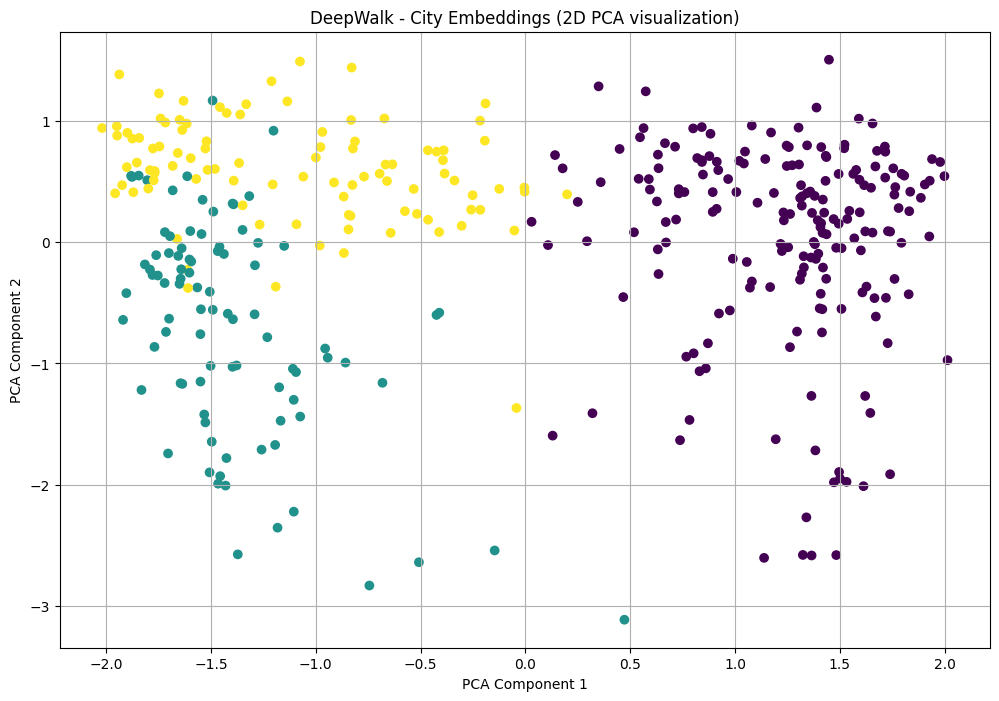

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 使用 PCA 降维到 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# 绘制散点图
plt.figure(figsize=(12, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans.labels_, cmap='viridis')

# 去掉为每个城市添加标签的部分
# for i, city in enumerate(G.nodes()):
#     plt.text(reduced_embeddings[i, 0] + 0.1, reduced_embeddings[i, 1] + 0.1, city, fontsize=9)

plt.title("DeepWalk - City Embeddings (2D PCA visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


In [33]:
from sklearn.metrics.pairwise import cosine_similarity

# 计算城市之间的相似度
similarity_matrix = cosine_similarity(embeddings)

# 打印第一个城市和其他城市的相似度
for i, city in enumerate(G.nodes()):
    print(f"城市: {city}, 相似度: {similarity_matrix[0, i]}")

城市: 000, 相似度: 1.0
城市: 13f, 相似度: 0.1571904569864273
城市: 8e3, 相似度: 0.27313417196273804
城市: a18, 相似度: 0.062020424753427505
城市: eda, 相似度: 0.2886606454849243
城市: 01a, 相似度: 0.459789901971817
城市: b5a, 相似度: 0.0705394372344017
城市: ea1, 相似度: 0.09621058404445648
城市: 03f, 相似度: 0.3050953149795532
城市: 1be, 相似度: 0.11431566625833511
城市: 3bc, 相似度: 0.08370863646268845
城市: 578, 相似度: 0.06611248850822449
城市: 5df, 相似度: 0.1465642750263214
城市: 5fb, 相似度: 0.0801704153418541
城市: 760, 相似度: 0.07878800481557846
城市: 792, 相似度: 0.18575671315193176
城市: 7ff, 相似度: 0.08572863042354584
城市: 90a, 相似度: 0.11120453476905823
城市: 974, 相似度: 0.05959238111972809
城市: bbb, 相似度: 0.1220015287399292
城市: cb5, 相似度: 0.10363523662090302
城市: ffe, 相似度: 0.09361083805561066
城市: 059, 相似度: 0.023266704753041267
城市: 022, 相似度: 0.11735093593597412
城市: 077, 相似度: 0.1459394246339798
城市: 0d7, 相似度: 0.025964142754673958
城市: 0dd, 相似度: 0.05176950618624687
城市: 1a3, 相似度: 0.14760230481624603
城市: 1e9, 相似度: 0.09235560894012451
城市: 1ed, 相似度: 0.09994006156921387
城市:

轮廓系数是评估聚类质量的常用指标，范围是 -1 到 1，值越大表示聚类效果越好。它同时考虑了簇内紧密度（每个点与所在簇中其他点的距离）和簇间分离度（每个点与最近簇的距离）。

值的意义：

值接近 +1：说明数据点与同簇内的点很接近，且与其他簇的点有很大区别，聚类效果好。

值接近 0：表示数据点可能位于两个簇的边界上，聚类效果一般。

值接近 -1：表示数据点可能被错误地归类到某个簇中，聚类效果差。

In [34]:
from sklearn.metrics import silhouette_score
score = silhouette_score(reduced_embeddings, kmeans.labels_)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.42610791325569153


## 保存嵌入表示

In [35]:
import numpy as np
import json

# 获取城市列表
cities = list(city_embeddings.keys())

# 将降维后的嵌入表示转换为列表格式
reduced_embeddings_list = reduced_embeddings.tolist()

# 保存城市和其对应的嵌入（将 NumPy 数组转换为列表）
city_embedding_dict = {city: reduced_embeddings[i].tolist() for i, city in enumerate(cities)}

# 将 city_embedding_dict 保存为 JSON 文件
with open('data_hh/result/encoder/城市嵌入编码_航班频率加权图.json', 'w') as f:
    json.dump(city_embedding_dict, f)

print("城市嵌入表示已保存。")

城市嵌入表示已保存。


In [36]:
city_embedding_dict

{'000': [-1.7769560813903809, 0.7703678011894226],
 '13f': [0.7314435839653015, 0.4355519413948059],
 '8e3': [0.5887065529823303, 0.5184971690177917],
 'a18': [0.24965864419937134, 0.33050715923309326],
 'eda': [-0.1904308795928955, 1.1407859325408936],
 '01a': [-1.7615394592285156, -0.1080864816904068],
 'b5a': [0.6350367665290833, 0.607966959476471],
 'ea1': [0.29376956820487976, 0.006817364599555731],
 '03f': [-0.9996919631958008, 0.6956532597541809],
 '1be': [0.8828257322311401, 0.8916029930114746],
 '3bc': [1.4480011463165283, 1.5014926195144653],
 '578': [0.9669572710990906, 0.5185450315475464],
 '5df': [0.8001297116279602, 0.9358465671539307],
 '5fb': [0.7315822243690491, 0.4002258777618408],
 '760': [1.2567540407180786, 0.7818331718444824],
 '792': [0.17746195197105408, 0.6068294644355774],
 '7ff': [1.0062273740768433, 0.4115965664386749],
 '90a': [0.02930554933845997, 0.16669026017189026],
 '974': [1.3029934167861938, 0.9422321915626526],
 'bbb': [0.4492667615413666, 0.7662703